In [1]:
!pwd

/Users/work/Documents/GitHub/molgroups/Diffraction/Python/Diffraction_fitting_fp


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import scipy.fft 
import molgroups as mol

In [3]:
# initialize canvas, two numpy arrays: area, nSLD; [200] (100Å, 0.5 Å stepsize)
# initialize with zeros
maxarea = 100
stepsize = 0.5
dimension = 300
aArea = np.zeros(dimension).tolist()
anSL  = np.zeros(dimension).tolist()
anSLD = np.zeros(dimension).tolist()

In [4]:
# initialize a BLM_quaternary object (standard constructor)
# set values for lipids using the init function (we do not do this here, we use the standard from constructor)
# set values using fnSet
#     sigma = 2.5, bulknsld = 0., startz = 10, l_lipid1 = l_lipid2 = 13.6, vf_bilayer = 1., everything else preset)
# write the area and nSLD out using fnWriteProfile onto the Canvas (Maxarea=100Å2)

BLM_quaternary_1 = mol.BLM_quaternary()
na1, nh1, nm1, va1, vm1, vh1, lh1 = 0.00760, 0.00461, 0.000468, 972.00, 98, 331.00, 9.56 
na2, nh2, nm2, va2, vm2, vh2, lh2 = 0, 0, 0, 0, 0, 0, 0 
na3, nh3, nm3, va3, vm3, vh3, lh3 = 0, 0, 0, 0, 0, 0, 0
vc, nc = 0, 0
BLM_quaternary_1.fnInit(va1, na1, vm1, nm1, vh1,nh1, lh1, va2, na2, vm2, nm2, 
                        vh2, nh2, lh2, va3, na3, vm3, nm3, vh3, nh3,lh3, vc, nc)

sigma, bulknsld, startz, l_lipid1, l_lipid2, vf_bilayer = 2.0, 9.4114E-06, 50, 11.6, 11.6, 1
BLM_quaternary_1.fnSet(sigma, bulknsld, startz, l_lipid1, l_lipid2, vf_bilayer)

In [5]:
dd, aArea, anSL = BLM_quaternary_1.fnWriteProfile(aArea, anSLD, dimension, stepsize, maxarea)
for i in range(len(aArea)):
    if aArea[i] != 0:
        anSLD[i] = anSL[i] / (aArea[i]*stepsize) * aArea[i]/dd + bulknsld * (1 - aArea[i]/dd)
    else:
        anSLD[i] = bulknsld
print(dd)

75.3448275862069


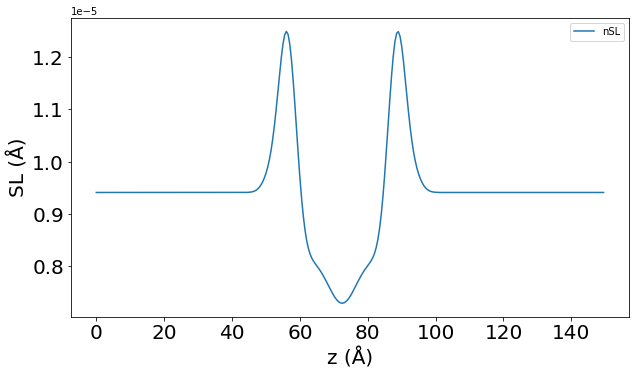

In [6]:
x = [stepsize * i for i in range(dimension)]
fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 5.5)
ax.plot(x, anSL)
plt.legend(['nSL'])
ax.set_ylabel('SL (Å)', fontsize=20)
ax.set_xlabel('z (Å)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.xlim([0, 200])
plt.show()

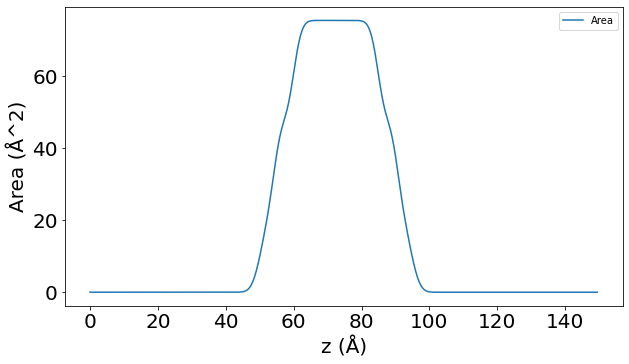

In [7]:
x = [stepsize * i for i in range(dimension)]
fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 5.5)
ax.plot(x, aArea)
plt.legend(['Area'])
ax.set_ylabel('Area (Å^2)', fontsize=20)
ax.set_xlabel('z (Å)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

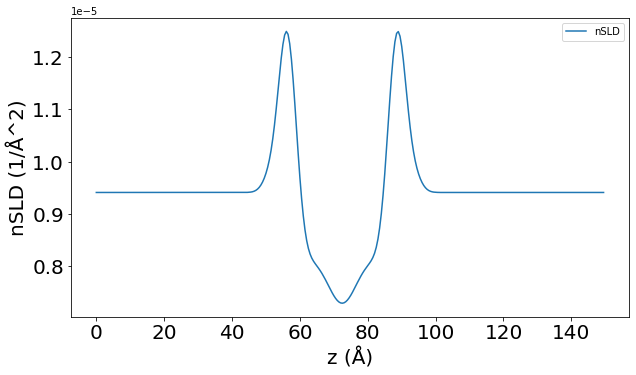

In [8]:
x = [stepsize * i for i in range(dimension)]
fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 5.5)
ax.plot(x, anSLD)
plt.legend(['nSLD'])
ax.set_ylabel('nSLD (1/Å^2)', fontsize=20)
ax.set_xlabel('z (Å)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.draw()

In [9]:
# identify bilayer center using the bilayer object (methyl1_z+0.5*methyl1_l)
# center bilayer on canvas
# |l-----------------------x-------------------------h|
center = BLM_quaternary_1.fnGetCenter()
center = center//stepsize
# calculate difference between
canvas_center = dimension//2
n = int(canvas_center - center)
centered_bilayer = np.roll(anSLD, n)
# symmetrize the bilayer around this center
# |l-----------------------x-------------------------h|          +
# |h-----------------------x-------------------------l|
# ------
# |lh----------------------x------------------------hl|
symmetrized_bilayer = np.add(centered_bilayer,centered_bilayer[::-1])*0.5
symmetrized_bilayer -= bulknsld
half_bilayer = symmetrized_bilayer[int(dimension/2):]

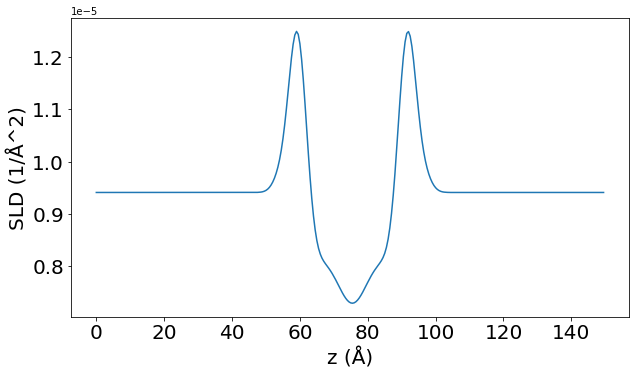

In [10]:
x = [stepsize*i for i in range(dimension)]

fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 5.5)
ax.plot(x, centered_bilayer)
#ax.legend(['model', 'experiment'], fontsize=16)
#ax.set_xlim([0, 50])
#ax.set_ylim([0, 2.5])
ax.set_ylabel('SLD (1/Å^2)', fontsize=20)
ax.set_xlabel('z (Å)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.figure.savefig("CenteredSLD.pdf")
plt.draw()

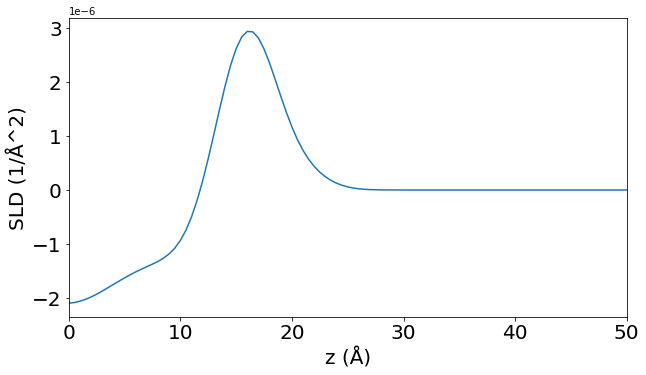

In [11]:
x = [stepsize * i for i in range(len(half_bilayer))]

fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 5.5)
ax.plot(x, half_bilayer)
#ax.legend(['model', 'experiment'], fontsize=16)
ax.set_xlim([0, 50])
#ax.set_ylim([0, 2.5])
ax.set_ylabel('SLD (1/Å^2)', fontsize=20)
ax.set_xlabel('z (Å)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.figure.savefig("HalfDiffProfile.pdf")
plt.draw()

In [12]:
# cosine tranform of the nSLD(z) canvas to get F(q)
dct_dimension = 5000
F = scipy.fft.dct(half_bilayer, n=dct_dimension)
F = np.abs(F)
x = np.array([np.pi/(2*dct_dimension*stepsize)*(2*i)  for i in range(int(dct_dimension))])

In [13]:
F2 = np.loadtxt("dopc.dat", delimiter=None, skiprows=1)
F2 = np.abs(F2)

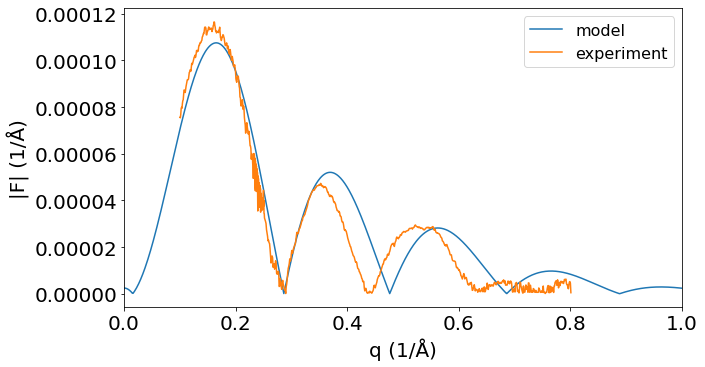

In [21]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 5.5)
ax.plot(x, F)
ax.plot(F2[:,0], F2[:,1]/16e3)
ax.legend(['model', 'experiment'], fontsize=16)
ax.set_xlim([0, 1])
#ax.set_ylim([0, 2.5])
ax.set_ylabel('|F| (1/Å)', fontsize=20)
ax.set_xlabel('q (1/Å)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.figure.savefig("ExpTheoComp.pdf")
plt.draw()

In [15]:
def modelformfactor(lq, bilayer, l_lipid, vf_bilayer, sigma, bulknsld, prefactor):
    
    #TODO: Think about how to set those variables more conveniently
    maxarea = 100
    stepsize = 0.5
    dimension = 300
    startz = 50
    
    aArea = np.zeros(dimension).tolist()
    anSL  = np.zeros(dimension).tolist()
    anSLD = np.zeros(dimension).tolist()
 
    bilayer.fnSet(sigma, bulknsld, startz, l_lipid, l_lipid, vf_bilayer)
    dd, aArea, anSL = bilayer.fnWriteProfile(aArea, anSLD, dimension, stepsize, maxarea)
    
    #TODO: speedup
    for i in range(len(aArea)):
        if aArea[i] != 0:
            anSLD[i] = anSL[i] / (aArea[i]*stepsize) * aArea[i]/dd + bulknsld * (1 - aArea[i]/dd)
        else:
            anSLD[i] = bulknsld

    center = bilayer.fnGetCenter()
    center = center//stepsize
    canvas_center = dimension//2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(anSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer,centered_bilayer[::-1])*0.5
    symmetrized_bilayer -= bulknsld
    half_bilayer = symmetrized_bilayer[int(dimension/2):]
    
    #TODO: Make sure that lq and x are roughly comparable
    dct_dimension = 5000
    F = scipy.fft.dct(half_bilayer, n=dct_dimension)
    F = np.abs(F)
    x = np.array([np.pi / (2*dct_dimension*stepsize)*(2*i)  for i in range(int(dct_dimension))])
    
    #interpolate (x, F) onto lq -> (lq, modelform)
    modelform =  np.interp(lq, x, F, left=None, right=None, period=None)*prefactor
    
    return modelform

In [16]:
bilayer = mol.BLM_quaternary()
na1, nh1, nm1, va1, vm1, vh1, lh1 = 0.00760, 0.00461, 0.000468, 972.00, 98, 331.00, 9.56 
na2, nh2, nm2, va2, vm2, vh2, lh2 = 0, 0, 0, 0, 0, 0, 0 
na3, nh3, nm3, va3, vm3, vh3, lh3 = 0, 0, 0, 0, 0, 0, 0
vc, nc = 0, 0
bilayer.fnInit(va1, na1, vm1, nm1, vh1,nh1, lh1, va2, na2, vm2, nm2, 
                        vh2, nh2, lh2, va3, na3, vm3, nm3, vh3, nh3,lh3, vc, nc)

F2 = np.loadtxt("dopc.dat", delimiter=None, skiprows=1)
F2 = np.abs(F2)
form_exp = F2[:,1]
#TODO: Talk to Stephanie about error bars
dform_exp = form_exp*0.05
q_exp = F2[:,0]

mf = modelformfactor(q_exp, bilayer, 11.6, 1.0, 2, 9.4114E-06, 17000)

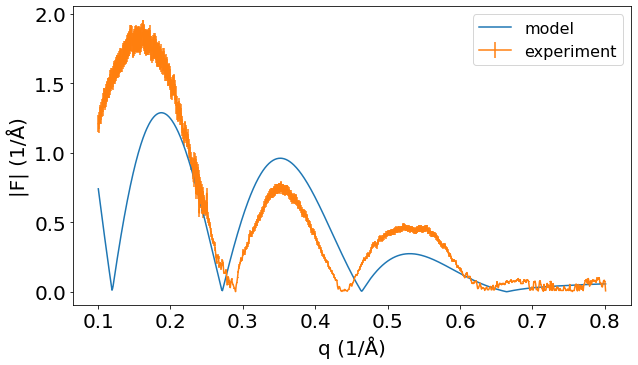

In [17]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 5.5)
ax.plot(q_exp, mf)
ax.errorbar(q_exp, form_exp, dform_exp)
ax.legend(['model', 'experiment'], fontsize=16)
# ax.set_xlim([0, 1])
#ax.set_ylim([0, 2.5])
ax.set_ylabel('|F| (1/Å)', fontsize=20)
ax.set_xlabel('q (1/Å)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.figure.savefig("ExpTheoComp.pdf")
plt.draw()